# SVM
## I. Importation des librairies

In [1]:
import csv
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from usefulCmdsAndFcns import get_metrics, plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

# 

## II. Lecture des descripteurs
Les descripteurs de toutes les musiques ont été calculé et enregistré dans un fchier csv. Il suffit de les lire afin d'entrainer le futur modèle

In [2]:
with open('../../inference/dataset.csv', newline='') as csvfile:
    data = list(csv.reader(csvfile))
data = np.array(data)

label_names = data[:,1024]
feature_values = data[:, :1024]

## III. Modèle SVM
Les données doivent être séparé en deux ensembles. Un premier pour pouvoir entrainer le modèle et le second pour pouvoir évaluer.

In [3]:
# split données
X_train, X_test, y_train, y_test = train_test_split(feature_values, label_names, test_size=0.33, random_state=43)

# SVM
svm = make_pipeline(preprocessing.StandardScaler(), LinearSVC())
svm.fit(X_train, y_train)

/home/nicolas/Documents/3A_ENSTA/ml_embedded/vultr-tensorflow/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC())])

## IV. Evaluation
Pour évaluer le modèle, on affichage la matrice de confusion et les différents scores.

Confusion matrix, without normalization
[[11  0  5  1  1  2  2  2  2  5]
 [ 1 24  0  1  0  0  1  0  1  2]
 [ 5  4 10  2  3  5  1  0  0  3]
 [ 3  0  6 16  5  4  4  1  2  9]
 [ 0  1  1  2 19  0  2  2  6  2]
 [ 0 10  6  0  0  9  0  1  3  2]
 [ 3  1  0  0  0  1 27  0  0  1]
 [ 1  2  1  5  3  1  0 12  1  1]
 [ 1  1  1  2  5  0  0  2 18  3]
 [ 4  4  3  1  4  3  0  1  0  7]]
Accuracy: 0.4636
Precision: 0.468
Recall: 0.4636
F1 Score: 0.457


/home/nicolas/Documents/3A_ENSTA/ml_embedded/vultr-tensorflow/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/Documents/3A_ENSTA/ml_embedded/vultr-tensorflow/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/Documents/3A_ENSTA/ml_embedded/vultr-tensorflow/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/Documents/3A_ENSTA/ml_embedded/vultr-tensorflow/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/nicolas/Documents/3A_ENSTA/ml_embedded/vultr-tensorflow/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: Converg

Scores SVM:  0.3969696969696971


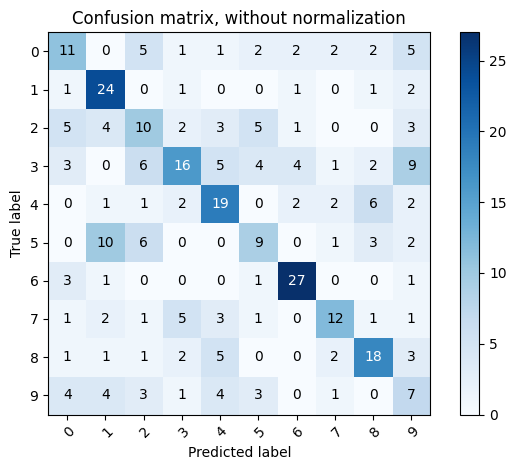

In [4]:
# evaluation du modele
plot_confusion_matrix(y_test,svm.predict(X_test))
get_metrics(y_test,svm.predict(X_test))
scores = cross_val_score(svm, X_test, y_test)
print("Scores SVM: ",scores.mean())
accuracy = svm.score(X_test, y_test)

Les performances sont correcte.

## V. Enregistrement

Enregistrement du modèle

In [5]:
# enregistrement du modele
with open('../../inference/SVC/model_svm.csv', 'w', encoding='UTF8') as f:
    # create the csv writer
    writer = csv.writer(f)

    # write a row to the csv file
    writer.writerow(svm['standardscaler'].scale_)
    writer.writerow(svm['standardscaler'].mean_)
    for i in range(10):
      writer.writerow(svm['linearsvc'].coef_[i,:])
    writer.writerow(svm['linearsvc'].intercept_)
    writer.writerow(svm['linearsvc'].classes_)

Codage des labels en indices

In [6]:
unique_label = np.unique(label_names)

# enc labelNames to indices
encName2Ind = preprocessing.LabelEncoder()
encName2Ind.fit(unique_label)
labelIndices_unique = encName2Ind.transform(unique_label)
labelIndices  = encName2Ind.transform(label_names)

# Conversion des noms des labels en indices
y_test = encName2Ind.transform(y_test)

Enregistrement de l'ensemble d'évaluation

In [7]:
txt = ""
txt += "#ifndef TEST_DATASET_H\n#define TEST_DATASET_H\n\n"
txt += "#define N_TEST_EXAMPLES " + str(X_test.shape[0]) + "\n"
txt += "#define N_FEATURES " + str(X_test.shape[1]) + "\n"
txt += "#define N_CLASSES 10\n\n"

txt += "float test_acc=" + str(accuracy) +";\n\n"

txt += "float X_test[N_TEST_EXAMPLES][N_FEATURES] = {\n"
for i in range(X_test.shape[0]-1):
    txt += "{"
    for j in range(X_test.shape[1]-1):
        txt += str(X_test[i,j]) +","
    txt += str(X_test[i,X_test.shape[1]-1]) + "},\n"
txt += "{"
for j in range(X_test.shape[1]-1):
    txt += str(X_test[X_test.shape[0]-1,j]) +","
txt += str(X_test[X_test.shape[0]-1,X_test.shape[1]-1]) + "}};\n\n"

txt += "int y_test[N_FEATURES]={"
for i in range(X_test.shape[0]-1):
    txt += str(y_test[i]) +","
txt += str(y_test[X_test.shape[0]-1]) +"};\n\n"

txt += "#endif"

# écriture du code dans le fichier
fichier = open("../../inference/SVC/test_dataset.h", "w")
fichier.write(txt)
fichier.close()